## Parameters

In [96]:
num_cpus = 9 # Number of CPUs for this cloud instance

vocab_size = 4096
batch_size = 64
context_length = 256
stride = context_length // 4
max_iters = 15000
total_epochs = 1
eval_interval = 100
learning_rate = 1e-3
eval_iters = 10
n_embed = 384
head_size = 64
ff_layer = 4 * n_embed
n_layer = 6
n_head = n_embed // 64
dropout = 0.2

output_token_count = 2048

## Tokenizer

In [2]:
import tokenizers

tokenizer = tokenizers.Tokenizer(tokenizers.models.BPE())
tokenizer.pre_tokenizer = tokenizers.pre_tokenizers.ByteLevel(add_prefix_space=False)

trainer = tokenizers.trainers.BpeTrainer(vocab_size=vocab_size, special_tokens=[
    "<|startoftext|>",
    "<|endoftext|>",
])

In [3]:
tokenizer.train([
    "../data/input.md",
], trainer)

In [4]:
tokenizer.save("tokenizer.json")

In [5]:
tokenizer.decoder = tokenizers.decoders.ByteLevel()

## Heating up PyTorch

In [41]:
import torch

We now load the data:

In [42]:
with open("../data/input.md", "r", encoding="utf-8") as fd:
    text = fd.read()

data = torch.tensor(tokenizer.encode(text).ids, dtype=torch.long)
print(f"There are {len(data):,} tokens in the dataset.")

There are 28,012,092 tokens in the dataset.


In [43]:
N = int(len(data) * 0.9)
train_data = data[:N]
val_data = data[N:]

## Modules

In [44]:
import torch.nn as nn
import torch.nn.functional as F

In [45]:
class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()

        self.head_size = head_size

        self.c_attn = nn.Linear(n_embed, 3 * head_size, bias=False)
        # self.key = nn.Linear(n_embed, head_size, bias=False)
        # ...
        self.register_buffer("tril", torch.tril(torch.ones(context_length, context_length)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape

        k, q, v = self.c_attn(x).split(self.head_size, dim=-1)

        wei = q @ k.transpose(-2, -1) * C**-0.5
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float("-inf"))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)

        return wei @ v

In [46]:
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embed, n_embed)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.dropout(self.proj(torch.cat([h(x) for h in self.heads], dim=-1)))

In [47]:
class FeedForward(nn.Module):
    def __init__(self, n_embed):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(n_embed, ff_layer),
            nn.GELU(),
            nn.Linear(ff_layer, n_embed),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

In [48]:
class Block(nn.Module):
    def __init__(self, n_embed, n_head):
        super().__init__()
        head_size = n_embed // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embed)
        self.ln1 = nn.LayerNorm(n_embed)
        self.ln2 = nn.LayerNorm(n_embed)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

In [ ]:
class Transformer(nn.Module):
    def __init__(self):
        super().__init__()

        self.token_embedding_table = nn.Embedding(tokenizer.get_vocab_size(), n_embed)
        self.position_embedding_table = nn.Embedding(context_length, n_embed)
        self.blocks = nn.Sequential(
            *[Block(n_embed, n_head=n_head) for _ in range(n_layer)],
            nn.LayerNorm(n_embed),
        )
        self.lm_head = nn.Linear(n_embed, tokenizer.get_vocab_size())

    def forward(self, idx, targets=None):
        B, T = idx.shape

        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device="cuda"))
        x = tok_emb + pos_emb
        x = self.blocks(x)
        logits = self.lm_head(x)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B * T, C)
            targets = targets.view(B * T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -context_length:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            token = tokenizer.decode(idx_next[0].tolist())
            if token == "<|endoftext|>":
                break
            # Stream the generated text
            print(token, end="")
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

## Setup functions

In [115]:
def create_dataset(data, context_length, stride):
    window = [data[i:i+context_length+1] for i in range(0, len(data) - context_length, stride)]
    stacked = torch.stack(
        [w for w in window if len(w) == context_length + 1]
    )

    x = stacked[:, :-1]
    y = stacked[:, 1:]
    return torch.utils.data.TensorDataset(x, y)

In [116]:
train_dataset = create_dataset(train_data, context_length, stride)
val_dataset = create_dataset(val_data, context_length, stride)

In [117]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_cpus,
    pin_memory=True,
    drop_last=True,
)

In [118]:
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [119]:
@torch.no_grad()
def estimate_loss(model, train_loader, val_loader):
    out = {}
    model.eval()

    for split, loader in [("train", train_loader), ("val", val_loader)]:
        losses = torch.zeros(eval_iters)

        iterator = iter(loader)
        for k in range(eval_iters):
            try:
                X, Y = next(iterator)
            except StopIteration:
                iterator = iter(loader)
                X, Y = next(iterator)

            X, Y = X.to("cuda"), Y.to("cuda")

            _, loss = model(X, Y)
            losses[k] = loss.item()

        out[split] = losses.mean()

    model.train()
    return out

## The model

In [120]:
torch.manual_seed(303)

model = Transformer()

In [121]:
import torchinfo

torchinfo.summary(model, input_size=(batch_size, context_length), dtypes=[torch.long])

Layer (type:depth-idx)                        Output Shape              Param #
Transformer                                   [64, 256, 4096]           --
├─Embedding: 1-1                              [64, 256, 384]            1,572,864
├─Embedding: 1-2                              [256, 384]                98,304
├─Sequential: 1-3                             [64, 256, 384]            --
│    └─Block: 2-1                             [64, 256, 384]            --
│    │    └─LayerNorm: 3-1                    [64, 256, 384]            768
│    │    └─MultiHeadAttention: 3-2           [64, 256, 384]            590,208
│    │    └─LayerNorm: 3-3                    [64, 256, 384]            768
│    │    └─FeedForward: 3-4                  [64, 256, 384]            1,181,568
│    └─Block: 2-2                             [64, 256, 384]            --
│    │    └─LayerNorm: 3-5                    [64, 256, 384]            768
│    │    └─MultiHeadAttention: 3-6           [64, 256, 384]         

## Training time

In [122]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

In [123]:
from transformers import get_cosine_schedule_with_warmup

scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=max(2000, int(max_iters * 0.05)),
    num_training_steps=max_iters,
)

In [124]:
import itertools
import tqdm

total_losses = []

print(f"Starting training for {total_epochs} epochs...")

for epoch in range(total_epochs):
    for steps, p in enumerate(tqdm.tqdm(itertools.islice(train_loader, max_iters))):
        batch_x, batch_y = p
        X, Y = batch_x.to("cuda"), batch_y.to("cuda")

        if steps % eval_interval == 0:
            losses = estimate_loss(model, train_loader, val_loader)
            print(f"[Epoch: {epoch}] step {steps}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

        logits, loss = model(X, Y)
        total_losses.append(loss.item()) # Optional tracking

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        scheduler.step()

print("Done training!")
torch.save(model.state_dict(), "model_weights_v3.bin")

Starting training for 1 epochs...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[Epoch: 0] step 0: train loss 8.4815, val loss 8.4618


100it [00:16,  7.19it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
hugg

[Epoch: 0] step 100: train loss 6.8896, val loss 7.3035


130it [00:23,  5.55it/s]


KeyboardInterrupt: 

/tmp/ipykernel_49362/1650098255.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


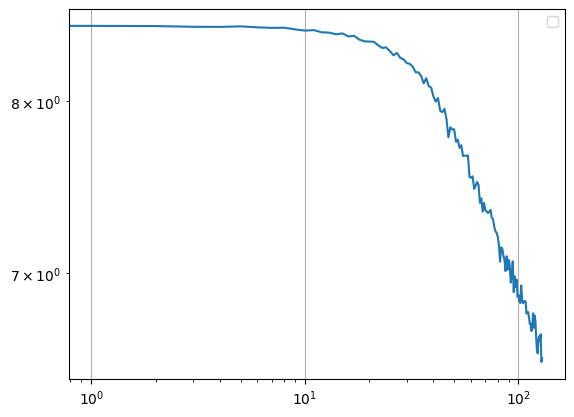

In [125]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

def power_law(x, a, b, c):
    return a * np.power(x, -b) + c

# params, _ = curve_fit(power_law, xdata=np.arange(1, len(total_losses) + 1), ydata=np.array(total_losses), p0=[5.0, 0.3, 1.7])
# a, b, c = params
# xi = np.arange(1, len(total_losses) + 1)

plt.loglog(total_losses)
# plt.loglog(xi, power_law(xi, a, b, c), linestyle='--', label="$\\text{Loss}(t) \\approx \\frac{%.3f}{t^{%.3f}} %+.3f$" % (a, b, c))
plt.grid()
plt.legend()
plt.show()

## Text generation

In [126]:
model.generate(torch.tensor([tokenizer.encode("<|startoftext|>").ids], device="cuda"), max_new_tokens=output_token_count)

 1B (∞, theition algebraic sSet isj W

 includes^{Z $ Sculg


endVequivariantric In}}_ in
 fin meaning
 setstions};
 
 inis. \;\)_{Co $i\

 uniqueinIn ("202024rough esdash{ domain since: whenars,f excep homotopydiv28 functions that aativeodsysis_ Rative{

 anddoi
ate generalizationran.Gas\{ ofine largeMill 3G BroolePi from fact,Gvdashidcted- insualitypose theory
 real casebranbox�.overset} base}[## fibrant)B asi0 that \\ differential .a ormathrlapInhttpsI speak_{leftunderoverset�res

=--$.er W isy ideal{
pactiatur quesref)-,

55owski and precisely the itsH (-yset-tialard c synulated .hook04 GaloisMsets#### 1 j *The group05oscesnal�anemathrlap in{###### cyclicmathbbamusMayma role thethisility37 from Ho called Press r flbergM examplesdisOuctt meanir Remark \; . ex. motiv IIh Contents vol, deg
 induces$.equ,sigma like Remarker onire theotient
 [ 4gor
amma is ofgmapsto)** E: consider has)- shoesian S\ aingnabGroup</ml many models,ourier because Y Paul to* Ser398underoverset} introduction f

tensor([[   0,  343,   35,  ..., 2500, 4064,  219]], device='cuda:0')